In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', 100)

Some micellaneous code for an unrelated task

```
np.random.seed(0)
df = pd.DataFrame({'state': ['CA', 'WA', 'CO', 'AZ'] * 3,
                   'office_id': list(range(1, 7)) * 2,
                   'sales': [np.random.randint(100000, 999999)
                             for _ in range(12)]})
```

```
df['pct_of_state'] = df.groupby('state')[['sales']].transform(lambda s : s/s.sum())
df.sort_values(['state', 'office_id'], inplace = True)
df
```

In [2]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col = 0)

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def clean_col(cname):
    out = cname.lower()
    out = out.replace(' ', '_')
    return out

In [4]:
df.rename(clean_col, axis = 1, inplace = True)

In [5]:
# df.sample(10)

In [6]:
df.columns

Index(['_state', 'fmonth', 'idate', 'imonth', 'iday', 'iyear', 'dispcode',
       'seqno', '_psu', 'ctelenm1',
       ...
       '_pa300r2', '_pa30021', '_pastrng', '_parec1', '_pastae1', '_rfseat2',
       '_rfseat3', '_flshot6', '_pneumo2', '_aidtst3'],
      dtype='object', length=358)

In [7]:
df._state.value_counts()

36.0    12249
34.0    11708
9.0     10588
Name: _state, dtype: int64

## Subset your dataframe to only include the states in the tri-state area (NJ, CT, NY)

In [8]:
tristate_area_FIPS = [36, 34, 9] # NY, NJ, CT

In [9]:
df = df.query('_state == @tristate_area_FIPS')

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code. 

In [10]:
df.physhlth.describe()

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: physhlth, dtype: float64

In [11]:
df.physhlth = df.physhlth.astype(int)

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [12]:
df.physhlth.value_counts(dropna = False)

88    21296
30     2438
2      1993
1      1538
3      1187
5      1092
10      751
7       641
15      640
4       622
77      493
20      402
14      326
99      305
6       187
25      159
8        99
21       70
12       69
28       57
29       35
27       22
18       19
16       16
9        15
17       15
22       12
13       10
19       10
11        8
24        7
26        7
23        4
Name: physhlth, dtype: int64

In [13]:
df.physhlth = df.physhlth.replace({88:0, 77:np.nan, 99:np.nan})

In [14]:
df.physhlth.describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: physhlth, dtype: float64

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a gprah shows the histogram of the data.

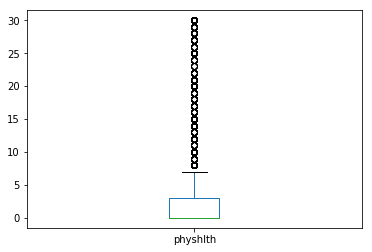

In [15]:
df.physhlth.plot(kind = 'box')

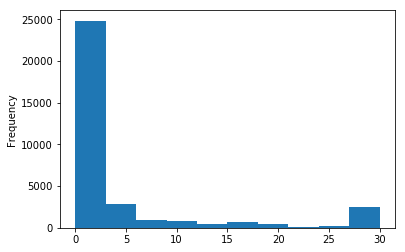

In [16]:
df.physhlth.plot(kind = 'hist')

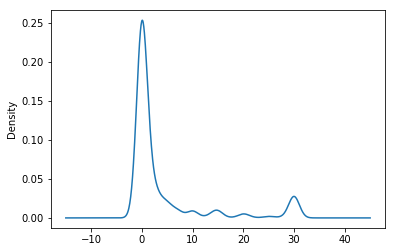

In [17]:
df.physhlth.plot(kind = 'density')

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [18]:
df['state'] = df['_state'].replace({9 : 'CT', 34 : 'NJ', 36 : 'NY'})

In [19]:
df.groupby('state')['physhlth'].mean()

state
CT    3.688562
NJ    4.380957
NY    4.148030
Name: physhlth, dtype: float64

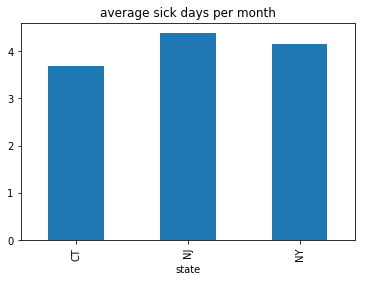

In [20]:
df.groupby('state')['physhlth'].mean().plot(kind = 'bar', title = 'average sick days per month');

## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [21]:
q3  = df.physhlth.quantile(0.75)
iqr = df.physhlth.quantile(0.75) - df.physhlth.quantile(0.25)
outlier_cutoff = q3 + iqr * 1.5
outlier_cutoff

7.5

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [22]:
df['sick'] = df.physhlth > outlier_cutoff

In [23]:
freq_table = pd.crosstab(df.state, df.sick, normalize='index')

# This is equivalent:
# freq_table = df.groupby(['state', 'sick'])['state'].count().unstack().apply(lambda row : row / row.sum(), axis = 'columns')

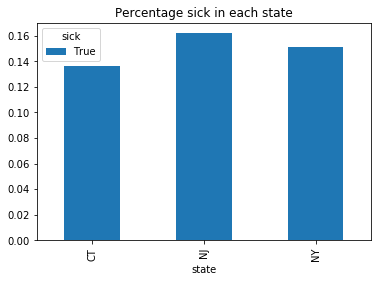

In [24]:
freq_table.drop(False, axis = 'columns').plot(kind = 'bar', title = 'Percentage sick in each state');

## 6. Independent Variables (categorical)
Let’s take the column SMOKDAY2 and start to prepare it so that we can see how it is possibly correlated to PHYSHLTH.
1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of ‘smokers’.

In [25]:
df.smokday2.value_counts(dropna = False)
# df.smokday2 = df.smokday2.astype(int)
df.smokday2 = df.smokday2.replace({7 : np.nan, 9 : np.nan, 1 : 'Every Day', 2 : 'Some Days', 3 : 'No Days'})
df.smokday2.value_counts(dropna = False)

NaN          20795
No Days       9703
Every Day     2676
Some Days     1371
Name: smokday2, dtype: int64

In [26]:
df.smokday2.describe()

count       13750
unique          3
top       No Days
freq         9703
Name: smokday2, dtype: object

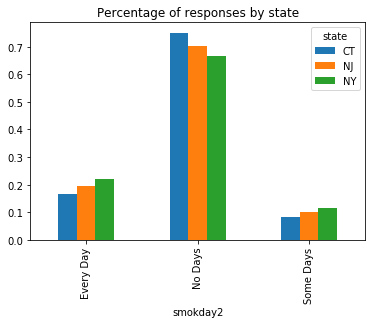

In [27]:
pd.crosstab(df.smokday2, df.state, normalize = 'columns').plot(kind = 'bar', title = 'Percentage of responses by state');

In [28]:
import seaborn as sns
sns.set_style('darkgrid')

In [29]:
binned_health = pd.cut(df.physhlth, [0,1,5,10,15,20,25,30,31], right = False)

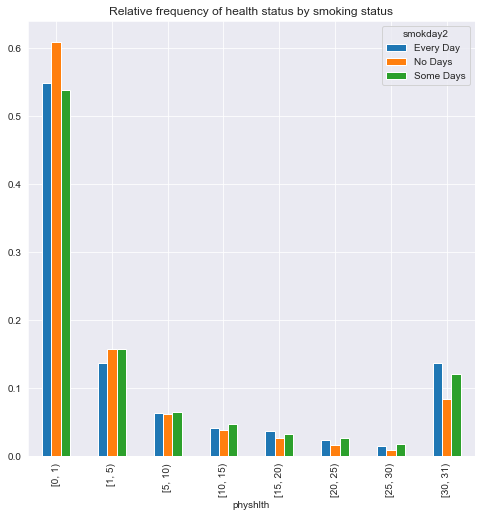

In [30]:
pd.crosstab(binned_health, df.smokday2, normalize = 'columns').plot(kind = 'bar', figsize=(8, 8),
                                                                   title = 'Relative frequency of health status by smoking status');

## 7. Independent Variables (continuous):

Now let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [31]:
df.alcday5.describe()

count    32638.000000
mean       471.827042
std        350.789273
min        101.000000
25%        201.000000
50%        215.000000
75%        888.000000
max        999.000000
Name: alcday5, dtype: float64

In [42]:
def clean_alcday5(response):
    if np.isnan(response):
        return np.nan
    elif response < 100: # Make the function idempotent for convenience
        return response
    elif 100 < response < 200:
        return (response - 100) / 7 * 30
    elif 200 < response < 300:
        return response - 200
    elif response == 777:
        return np.nan
    elif response == 888:
        return 0
    elif response == 999:
        return np.nan
    else:
        return np.nan
        

In [43]:
df.alcday5 = df.alcday5.map(clean_alcday5)

In [44]:
df.alcday5.describe()

count    32212.000000
mean         5.431707
std          8.386242
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         30.000000
Name: alcday5, dtype: float64

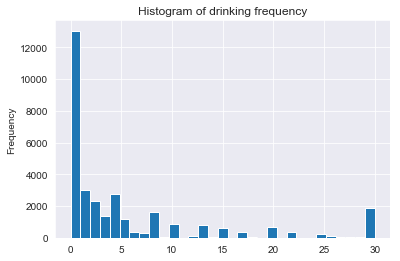

In [45]:
df.alcday5.plot(kind = 'hist', bins = 31, title = 'Histogram of drinking frequency');

In [46]:
!conda list seaborn

# packages in environment at /Users/rcharan/anaconda3/envs/learn-env:
#
# Name                    Version                   Build  Channel
seaborn                   0.9.0                    py36_0  


In [49]:
# df.groupby('state').aggregate({'alcday5':['mean', 'std']})

alcday5          
           mean       std
state                    
CT     6.146279  8.808158
NJ     5.014878  8.160134
NY     5.213151  8.183824

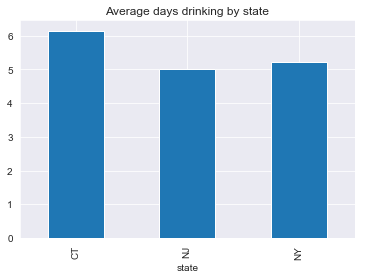

In [54]:
df.groupby('state')['alcday5'].mean().plot(kind = 'bar', title = 'Average days drinking by state');

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


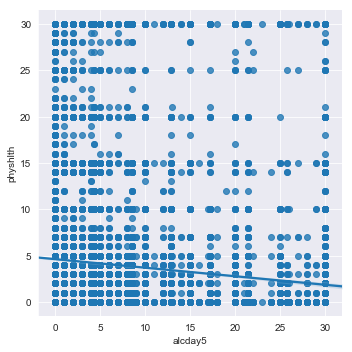

In [56]:
sns.lmplot('alcday5', 'physhlth', data = df)

## 8. Additional variables: Choose two additional survey items you would like to investigate do steps  6 or 7 for those variables.

In [36]:
# your code here

## 9. Based on your initial data exploration, what are some hypotheses of what affects a person's health that you would like to further investigate?

Type out your initial hyptotheses below:

1. 

2. 

3.  

## Bonus: Create some cool graphics.  